# This notebook has two parts:
1. Naive train Mobilenet model
2. Perform non-targeted and targeted attack on the trained model and record the results

In [5]:
from __future__ import print_function, division
import torch
import torchvision
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import skimage
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sklearn.metrics as metrics

In [7]:
print(torch.__version__,torchvision.__version__,pd.__version__,skimage.__version__,np.__version__,
      plt.__version__, cv2.__version__,sklearn.__version)

AttributeError: module 'matplotlib.pyplot' has no attribute '__version__'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# I.Naive Training

In [3]:
class BanknoteDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.labels.iloc[idx, -1])
        image = io.imread(img_name)
        image = cv2.resize(image, (256,256), interpolation=cv2.INTER_LINEAR)
        label = self.labels.iloc[idx, :-1]
        label = np.array(label)
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image.astype(np.int)),
                'label': torch.from_numpy(label.astype(np.int))}

In [4]:
#training set use batch 50
my_batch_size = 50
root_dir = "ThaiCurrencies"
train_data = BanknoteDataset("one_hot_labels.csv", root_dir, transform = transforms.Compose([ToTensor()]))
train_data_loader = DataLoader(train_data, batch_size=my_batch_size, shuffle=True, num_workers=0)

#小数据集就用 batch 4
test_data = BanknoteDataset('test_data.csv', root_dir, transform = transforms.Compose([ToTensor()]))
test_data_loader = DataLoader(test_data, batch_size=4, shuffle=True, num_workers=0)

val_data = BanknoteDataset('val_data.csv', root_dir, transform = transforms.Compose([ToTensor()]))
val_loader = DataLoader(test_data, batch_size=4, shuffle=True, num_workers=0)

data_pd = pd.DataFrame()

In [5]:
#preperation - 这几行不要重复运行
criterion = nn.CrossEntropyLoss().to(device)
train_loss = []
val_loss = []
acc_t = []
acc_v = []

In [6]:
#train训练，validation评测，往accuracy和loss后面append数据
def train_eval(num_epoch,learning_rate,start,max_accu = 0):
    #start 就是为了记录在这个lr之前train了多少epoch
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    temp = 0
    net.to(device)
    for epoch in range(num_epoch):
        net.train()
        class_correct=0
        class_total =0
        for i, data in enumerate(train_data_loader):
            inputs = data['image'].float().to(device)
            labels = data['label'].float().to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            loss.backward()
            optimizer.step()
            temp+=loss.item()
            #accuracy below
            c = (torch.max(outputs, 1)[1] == torch.max(labels, 1)[1]).squeeze()
            for i in range(len(c)):
                if(c[i]):
                    class_correct += 1
                class_total += 1
        acc_t.append( class_correct/class_total )
        #loss below
        train_loss.append(temp/len(train_data_loader))
        #reset temp
        temp = 0

        net.eval()
        class_correct=0 
        class_total =0
        for i, data in enumerate(val_loader):
            inputs = data['image'].float().to(device)
            labels = data['label'].float().to(device)
            outputs = net(inputs)
            loss = criterion(outputs, torch.max(labels, 1)[1])
            temp+=loss.item()
            #accuracy below
            c = (torch.max(outputs, 1)[1] == torch.max(labels, 1)[1]).squeeze()
            for i in range(len(c)):
                if(c[i]):
                    class_correct += 1
                class_total += 1
        accu = class_correct/class_total
        acc_v.append(accu)
        
        #loss below
        ave_loss = temp/len(val_loader)
        val_loss.append(ave_loss)
        print('epoch',epoch + start,end = ' ')
        print("Validation loss %f" %  ave_loss)
        #reset temp
        temp = 0
        #每十个epoch存一下model
        k = epoch+start+1
        if(k%10==0):
            file_name = 'MobileNet/epoch'+str(k)+'lr'+str(learning_rate)+'.pth'
            torch.save(net.state_dict(), file_name)
        max_accu = max_accu
        if(accu>max_accu and accu>0.94):
            max_accu = accu
            file_name = 'MobileNet/max_'+str(accu)+ '_lr'+str(learning_rate)+'epoch'+str(k)+'.pth'
            torch.save(net.state_dict(), file_name)
    data_pd = pd.DataFrame({'train_loss':train_loss,
                            'val_loss': val_loss,
                            'acc_t':acc_t,
                            'acc_v':acc_v})
    return max_accu,data_pd
    

In [118]:
#这就是在跑，疯狂地跑
net = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=False)
max_accu,data_pd=train_eval(num_epoch=11,learning_rate=0.001,start = 0)
print('Finished Training')

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to C:\Users\hands/.cache\torch\hub\v0.6.0.zip


epoch 0 Validation loss 0.944535
epoch 1 Validation loss 0.182530
epoch 2 Validation loss 0.194949
epoch 3 Validation loss 1.091131
epoch 4 Validation loss 0.125131
epoch 5 Validation loss 0.243814
epoch 6 Validation loss 0.107592
epoch 7 Validation loss 0.884282
epoch 8 Validation loss 0.050418
epoch 9 Validation loss 1.374666
epoch 10 Validation loss 0.148719


KeyboardInterrupt: 

In [122]:
max_accu,data_pd=train_eval(num_epoch=30,learning_rate=0.001,start = 11)
print('Finished Training')

epoch 11 Validation loss 0.261001
epoch 12 Validation loss 0.099261
epoch 13 Validation loss 0.031808
epoch 14 Validation loss 0.058033
epoch 15 Validation loss 0.135669
epoch 16 Validation loss 0.049281
epoch 17 Validation loss 1.360210
epoch 18 Validation loss 0.220144
epoch 19 Validation loss 0.117954
epoch 20 Validation loss 0.192886
epoch 21 Validation loss 0.058977
epoch 22 Validation loss 0.237935
epoch 23 Validation loss 0.062633
epoch 24 Validation loss 0.055381
epoch 25 Validation loss 0.114803
epoch 26 Validation loss 0.143229
epoch 27 Validation loss 0.073488
epoch 28 Validation loss 0.121863
epoch 29 Validation loss 0.111507
epoch 30 Validation loss 0.110530
epoch 31 Validation loss 0.100354
epoch 32 Validation loss 0.056684
epoch 33 Validation loss 0.045511
epoch 34 Validation loss 0.050705
epoch 35 Validation loss 0.049072
epoch 36 Validation loss 0.060653
epoch 37 Validation loss 0.404628
epoch 38 Validation loss 0.050001
epoch 39 Validation loss 0.246534
epoch 40 Valid

In [126]:
max_accu,data_pd=train_eval(num_epoch=20,learning_rate=0.0005,start = 41)
print('Finished Training')

epoch 41 Validation loss 0.091936
epoch 42 Validation loss 0.041514
epoch 43 Validation loss 0.074645
epoch 44 Validation loss 0.102206
epoch 45 Validation loss 0.086530
epoch 46 Validation loss 0.080378
epoch 47 Validation loss 0.227135
epoch 48 Validation loss 0.104004
epoch 49 Validation loss 0.029839
epoch 50 Validation loss 0.053935
epoch 51 Validation loss 0.028340
epoch 52 Validation loss 0.040456
epoch 53 Validation loss 0.069294
epoch 54 Validation loss 0.020479
epoch 55 Validation loss 0.031988
epoch 56 Validation loss 0.010458
epoch 57 Validation loss 0.016277
epoch 58 Validation loss 0.033353
epoch 59 Validation loss 0.085033
epoch 60 Validation loss 0.055848
Finished Training


## Naive Training Result Visualization

In [127]:
#Store the model and the training/validation curves
data_pd.to_csv('train_val_loss&acc.csv')
file_name = 'final.pth'
torch.save(net.state_dict(), file_name)

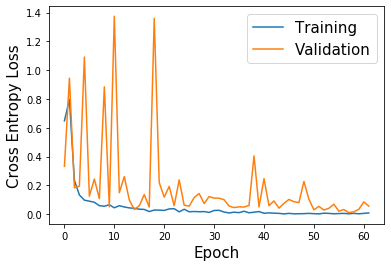

In [36]:
plt.plot(range(len(train_loss)),train_loss)
plt.plot(range(len(val_loss)),val_loss)
plt.xlabel('Epoch',size = 15)
plt.ylabel('Cross Entropy Loss',size = 15)
labels = ['Training','Validation']
plt.legend(labels, prop={'size': 15})
plt.savefig("loss_epoch4",dpi = 300)

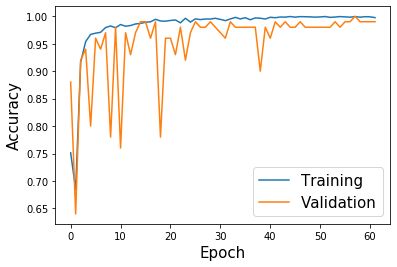

In [37]:
#
plt.plot(range(len(acc_t)),acc_t)
plt.plot(range(len(acc_v)),acc_v)
plt.xlabel('Epoch',size = 15)
plt.ylabel('Accuracy',size = 15)
labels = ['Training','Validation']
plt.legend(labels, prop={'size': 15})
plt.savefig("accuracy4",dpi = 300)

In [7]:
#loading model

#PATH= 'MobileNet/final57.pth'
#net = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
#net.load_state_dict(torch.load(PATH))

Using cache found in C:\Users\hands/.cache\torch\hub\pytorch_vision_v0.6.0


<All keys matched successfully>

## Testing and Training accuracy

In [8]:
#seperate class accuracy - test set
net.eval()
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
net.to(device)
with torch.no_grad():
    for i, data in enumerate(test_data_loader):
        images = data['image'].float().to(device)
        label = data['label'].float().to(device)
        outputs = net(images)
        
        #print(torch.max(outputs, 1)[1])
        #print(torch.max(label, 1)[1])
        
        cat_outputs = torch.max(outputs, 1)[1]
        cat_label = torch.max(label, 1)[1]
        c = (cat_outputs == cat_label).squeeze()
        for i in range(len(c)):
            lab = cat_label[i]
            if(c[i]):
                class_correct[lab] += 1
            class_total[lab] += 1
print(class_correct)
print(class_total)
for i in range(5):
    print('Testing Accuracy class %2d: %2d %%' % (i,100 * class_correct[i] / class_total[i]))
    #130 epoch

[20.0, 20.0, 20.0, 20.0, 20.0]
[20.0, 20.0, 20.0, 20.0, 20.0]
Testing Accuracy class  0: 100 %
Testing Accuracy class  1: 100 %
Testing Accuracy class  2: 100 %
Testing Accuracy class  3: 100 %
Testing Accuracy class  4: 100 %


In [58]:
wrong_pred_image = []
net.eval()
class_correct = 0
class_total = 0
net.to(device)
with torch.no_grad():
    for i, data in enumerate(train_data_loader):
        images = data['image'].float().to(device)
        label = data['label'].float().to(device)
        outputs = net(images)
        
        #print(torch.max(outputs, 1)[1])
        #print(torch.max(label, 1)[1])
        
        cat_outputs = torch.max(outputs, 1)[1]
        cat_label = torch.max(label, 1)[1]
        c = (cat_outputs == cat_label).squeeze()
        for i in range(len(c)):
            if(c[i]):
                class_correct += 1
            else:
                wrong_pred_image.append(images[i])
            class_total += 1
print(class_correct)
print(class_total)
print('Training Accuracy  %2d %%' % (100 * class_correct / class_total))

24807
24809
Training Accuracy  99 %


# II. Adversarial Attack 

In [7]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad, targeted = None):
    sign_data_grad = data_grad.sign()
    if(targeted):
        perturbed_image = image - epsilon*sign_data_grad
    else:
        perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 255)
    return perturbed_image

def plot_confusion_matrix(y_true,y_pred,eps,acc):
    #confusion_matrix = metrics.confusion_matrix(y_true,y_pred)
    confusion_matrix = order_matrix(y_true,y_pred)
    acc_confusion_matrix = confusion_matrix/20
    plt.imshow(acc_confusion_matrix,interpolation = 'nearest',cmap = 'Blues')
    plt.ylabel('True Label',size = 15)
    plt.xlabel('Predicted Label',size = 15)
    plt.xticks(ticks = [0,1,2,3,4],labels = (20,50,100,500,1000))
    plt.yticks(ticks = [0,1,2,3,4],labels = (20,50,100,500,1000))
    plt.colorbar()
    plt.title('Epsilon:{}, Accuracy:{:.2f}%'.format(eps,acc*100))
    for i in range(len(confusion_matrix)):
        for j in range(len(confusion_matrix)):
            count = confusion_matrix[j][i]
            plt.text(i,j,'{:1}\n{:1}%'.format(count,count/0.2),horizontalalignment='center',
                     verticalalignment='center',color = 'white' if count>11 else 'black')
    #plt.savefig('eps%dacc%d'%(eps,acc*100),dpi = 300)
    
    
def fgsm_test(epsilons,target_class = None):
    y_true = []
    y_pred = []
    acc = []
    adv_ex = None
    acc_by_class = list([] for i in range(5))
    for epsilon in epsilons:
        correct = 0
        total = 0
        acc_cnt_class = list(0 for i in range(5))
        for i_batch, sample_batched in enumerate(test_data_loader):
            data, label_batch = sample_batched['image'].float().to(device), sample_batched['label'].float().to(device)
            batch_size = len(data)
            data.requires_grad = True
            outputs = net(data)
            if(target_class):
                target_label = torch.tensor(list(target_class for i in range(4))).to(device)
                loss = criterion(outputs,target_label)
            else:
                loss = criterion(outputs,torch.max(label_batch, 1)[1])
            net.zero_grad()
            loss.backward()
            data_grad = data.grad.data
            p_data = fgsm_attack(data, epsilon, data_grad, target_class)
            p_outputs = net(p_data)

            c = (torch.max(p_outputs,1)[1] == torch.max(label_batch,1)[1])
            for i in range(len(c)):
                pred = torch.max(p_outputs,1)[1][i].cpu().numpy()
                true = torch.max(label_batch,1)[1][i].cpu().numpy()
                y_pred.append(pred)
                y_true.append(true)
                if(c[i]):
                    correct+=1
                    acc_cnt_class[torch.max(label_batch,1)[1][i]]+=1
                total+=1
            if adv_ex==None:
                adv_ex=[torch.max(label_batch,1)[1],torch.max(p_outputs,1)[1],data,p_data]
        acc.append(correct/total)
        for i in range(5):
            acc_by_class[i].append(acc_cnt_class[i]/20)
        if(epsilon%1==0):
            print('epsilon %.2f : %.2f' %( epsilon , correct/total))
    return epsilons,acc,acc_by_class,y_true,y_pred,adv_ex
            #grid = utils.make_grid(p_data.int())
            #plt.figure(figsize = (10,10))

        #plt.imshow(grid.cpu().detach().numpy().transpose((1, 2, 0)))

In [8]:
def order_matrix(y_true,y_pred):
    temp = metrics.confusion_matrix(y_true,y_pred)
    confusion_matrix = temp.copy()
    confusion_matrix[0] = temp[2]
    confusion_matrix[1] = temp[3]
    confusion_matrix[2] = temp[0]
    confusion_matrix[3] = temp[4]
    confusion_matrix[4] = temp[1]
    temp = confusion_matrix.copy()
    for i in range(5):
        confusion_matrix[i][0] = temp[i][2]
        confusion_matrix[i][1] = temp[i][3]
        confusion_matrix[i][2] = temp[i][0]
        confusion_matrix[i][3] = temp[i][4]
        confusion_matrix[i][4] = temp[i][1]
    return confusion_matrix

## Adversarial Attack Results Visualization

In [12]:
PATH= 'MobileNet_adv/final_eps2.pth'
net = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True).to(device)
net.load_state_dict(torch.load(PATH))

Using cache found in C:\Users\hands/.cache\torch\hub\pytorch_vision_v0.6.0


<All keys matched successfully>

epsilon 0.00 : 0.75


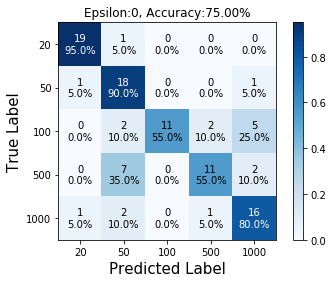

epsilon 1.00 : 0.65


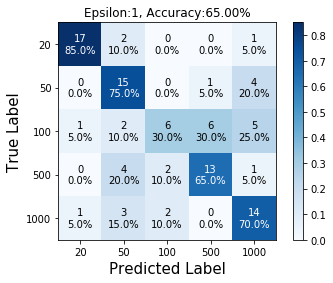

epsilon 2.00 : 0.55


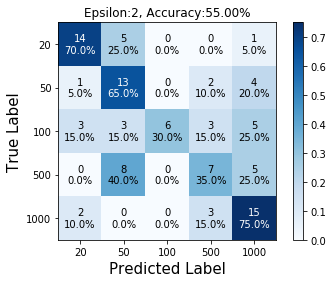

epsilon 3.00 : 0.57


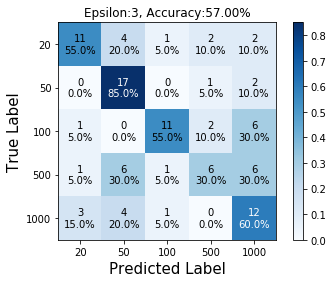

In [13]:
#non targeted
for i in range(4):
    _,acc,_,ytrue,ypred,_ = fgsm_test([i])
    plot_confusion_matrix(ytrue,ypred,i,acc[0])
    plt.savefig('MobileNet/eps%d'%(i),dpi = 300)
    plt.show()

epsilon 2.00 : 0.36
true label: tensor(4, device='cuda:0') 
 predicted label: tensor(0, device='cuda:0')


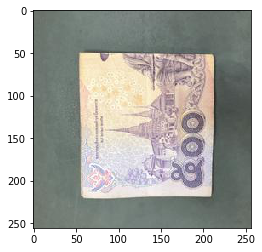

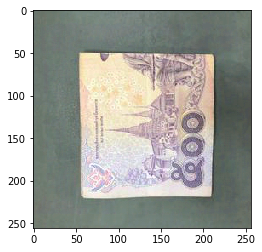

In [138]:
_,_,_,_,_,ex = fgsm_test([2])
print('true label:',ex[0][0],"\n predicted label:",ex[1][0])
plt.imshow(ex[2][0].cpu().detach().numpy().transpose((1,2,0)).astype('int'))
plt.savefig('eps2_',dpi=30)
plt.show()
plt.imshow(ex[3][0].cpu().detach().numpy().transpose((1,2,0)).astype('int'))
plt.savefig('',dpi=30)

epsilon 2.00 : 0.59


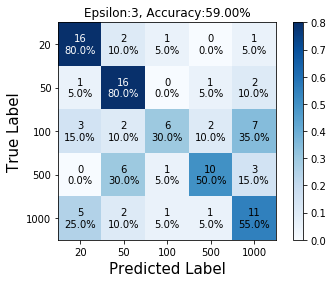

epsilon 2.00 : 0.61


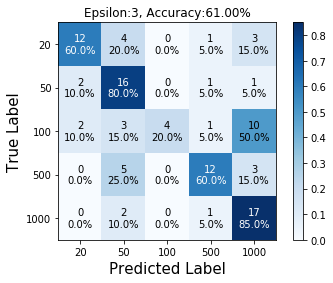

epsilon 2.00 : 0.54


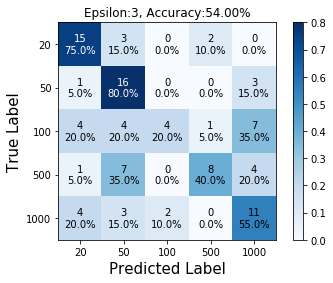

epsilon 2.00 : 0.60


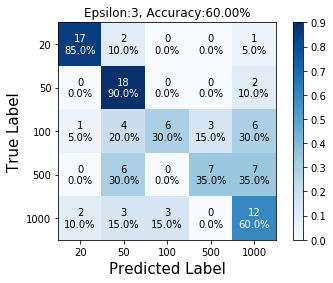

epsilon 2.00 : 0.57


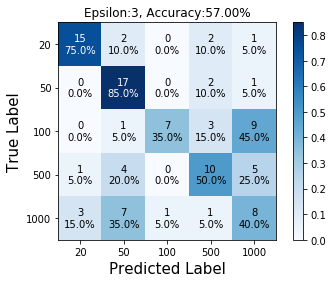

In [15]:
classes = [100,1000,20,50,500]
for i in range(5):
    _,acc,_,ytrue,ypred,_ = fgsm_test([2],i)
    plot_confusion_matrix(ytrue,ypred,3,acc[0])
    plt.show()

epsilon 0.00 : 1.00
epsilon 1.00 : 0.75
epsilon 2.00 : 0.36
epsilon 3.00 : 0.26
epsilon 4.00 : 0.25
epsilon 5.00 : 0.24


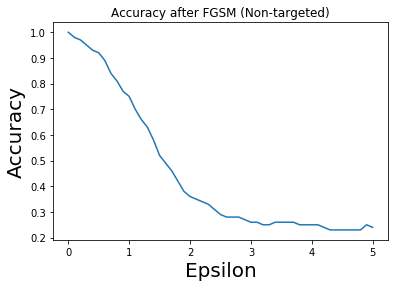

In [22]:
epsilons= np.linspace(0,5,51)
x_eps,y_acc,acc_bc,_,_,_ = fgsm_test(epsilons)
plt.xlabel('Epsilon',size = 20)
plt.ylabel('Accuracy',size = 20)
plt.plot(x_eps,y_acc)
plt.title('Accuracy after FGSM (Non-targeted)')
plt.savefig('MobileNet/57_acc_epsilon',dpi=300)

epsilon 0.00 : 1.00
epsilon 5.00 : 0.24


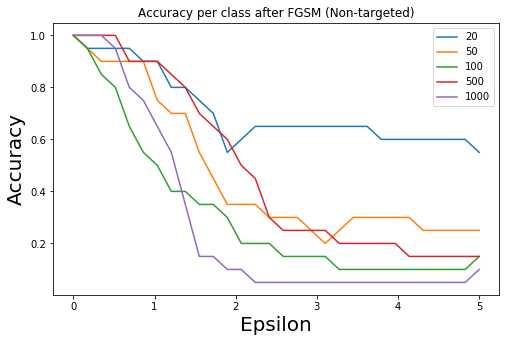

In [210]:
epsilons= np.linspace(0,5,30)
_,_,acc_bc,_,_,_ = fgsm_test(epsilons)
plt.xlabel('Epsilon',size = 20)
plt.ylabel('Accuracy',size = 20)
for i in [2,3,0,4,1]:
    plt.plot(epsilons,acc_bc[i])
labels = [20,50,100,500,1000]
plt.legend(labels, prop={'size': 10})
plt.title('Accuracy per class after FGSM (Non-targeted)')
plt.savefig('MobileNet/acc_epsilon_class',dpi=300)

Using cache found in C:\Users\hands/.cache\torch\hub\pytorch_vision_v0.6.0


epsilon 0.00 : 0.76
epsilon 1.00 : 0.61
epsilon 2.00 : 0.59
epsilon 3.00 : 0.50
epsilon 4.00 : 0.46
epsilon 5.00 : 0.48


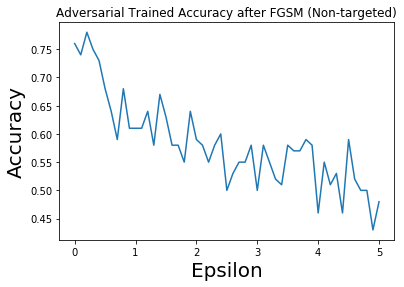

In [23]:
epsilons= np.linspace(0,5,51)
net = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True).to(device)
net.load_state_dict(torch.load('MobileNet_adv/final.pth'))
x_eps,y_acc,_,_,_,_ = fgsm_test(epsilons)
plt.xlabel('Epsilon',size = 20)
plt.ylabel('Accuracy',size = 20)
plt.plot(x_eps,y_acc)
plt.title('Adversarial Trained Accuracy after FGSM (Non-targeted)')
plt.savefig('MobileNet_adv/acc_comparison',dpi=300)

epsilon 0.00 : 1.00
epsilon 5.00 : 0.24


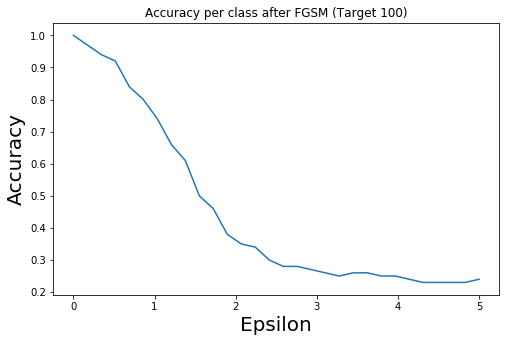

epsilon 0.00 : 1.00
epsilon 5.00 : 0.35


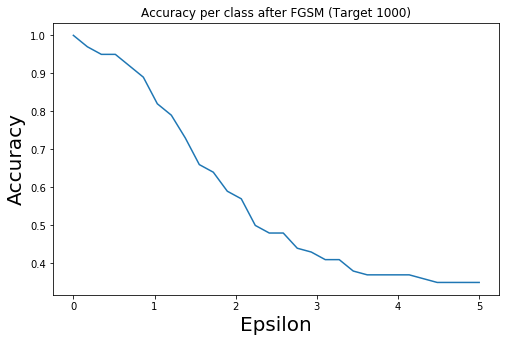

epsilon 0.00 : 1.00
epsilon 5.00 : 0.30


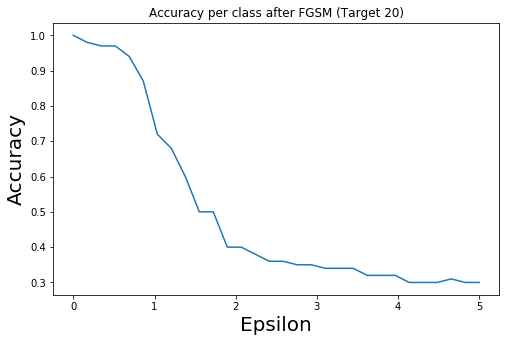

epsilon 0.00 : 1.00
epsilon 5.00 : 0.22


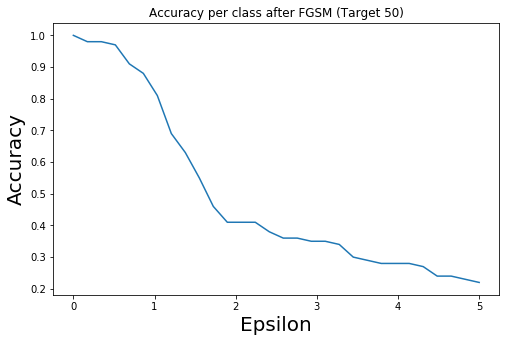

epsilon 0.00 : 1.00
epsilon 5.00 : 0.16


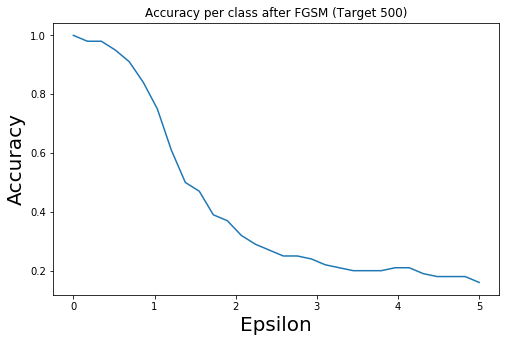

In [214]:
for i in range(5):
    epsilons= np.linspace(0,5,30)
    x_eps,y_acc,acc_bc,_,_,_ = fgsm_test(epsilons,i)
    plt.xlabel('Epsilon',size = 20)
    plt.ylabel('Accuracy',size = 20)
    plt.plot(x_eps,y_acc)
    plt.title('Accuracy per class after FGSM (Target %d)' % classes[i])
    plt.show()

In [207]:
net.eval()
p_data = []
for i_batch, sample_batched in enumerate(test_data_loader):
    data, label_batch = sample_batched['image'].float().to(device), sample_batched['label'].float().to(device)
    data.requires_grad = True
    outputs = net(data)
    loss = criterion(outputs, torch.max(label_batch, 1)[1])
    net.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    for i in [0,3,5,15]:
        p_data.append(fgsm_attack(data, i, data_grad))
    break
print('original')

original


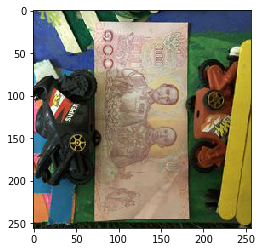

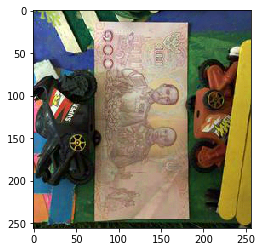

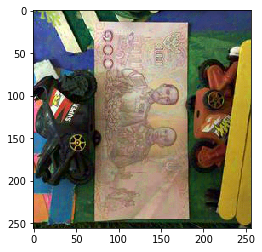

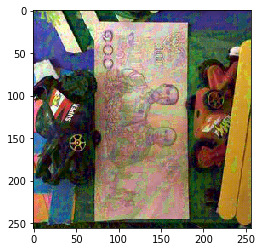

In [208]:
for i in range(4):
    plt.imshow(p_data[i][0].cpu().detach().numpy().transpose((1,2,0)).astype('int'))
    plt.show()